In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *

DATA_TRAIN_PATH = '../../../Data-Project1/train.csv' # TODO: add a file Data-Project1 with the train data 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
from helpers import *

# Standardize the input data
stx, mean_stx, std_x = standardize(tX)

In [5]:
# TODO: Get rid of the -999 in the data

## Do your thing crazy machine learning thing here :) ...

In [93]:
# Initialize parameters
gamma = 0.01
lambda_ = 0.1
max_iters = 10

## Attempt to preprocess the data and the features

> Get rid of the Features that does not provide any more information than the background

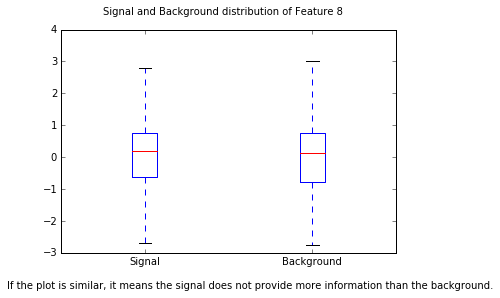

In [7]:
idx_f = 7
signal = stx[np.where(y == 1), idx_f + 1]
background = stx[np.where(y == -1), idx_f + 1]

plot = plt.figure()
plt.boxplot([signal, background], 0, '')
plt.xticks([1, 2], ['Signal', 'Background'])
plot.suptitle('Signal and Background distribution of Feature {f}'.format(f = idx_f + 1))

textvar = plot.text(0, 0, 'If the plot is similar, it means the signal does not provide more information than the background.')

## Linear regression using Gradient Descent 

In [8]:
from costs import *

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - tx @ w
    return -(tx.T @ e)/len(y)

def least_squares_GD(y, tx, gamma, max_iters):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    w = np.zeros(tx.shape[1])
    ws = [np.copy(w)]
    losses = []
    for n_iter in range(max_iters):
        # compute gradient with mse
        grad = compute_gradient(y, tx, w)
        
        # update w
        w = w - (gamma*grad)
        
        # calculate the cost with mse
        loss = compute_loss(y, tx, w)
        
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}".format(
              bi=n_iter, ti=max_iters - 1, l=loss))
    print("Optimal weights: {w}".format(w=ws[tx.shape[1]]))
    return losses, ws

least_squares_GD(y, stx, gamma, max_iters)

Gradient Descent(0/99): loss=0.45383148038975835
Gradient Descent(1/99): loss=0.4310979587324953
Gradient Descent(2/99): loss=0.41538321133630235
Gradient Descent(3/99): loss=0.4039178092406891
Gradient Descent(4/99): loss=0.39532813034051306
Gradient Descent(5/99): loss=0.38874321747505025
Gradient Descent(6/99): loss=0.38358837180705296
Gradient Descent(7/99): loss=0.379476061272276
Gradient Descent(8/99): loss=0.3761393708840319
Gradient Descent(9/99): loss=0.3733904841335668
Gradient Descent(10/99): loss=0.37109444248742285
Gradient Descent(11/99): loss=0.36915232673600373
Gradient Descent(12/99): loss=0.36749030408999545
Gradient Descent(13/99): loss=0.3660523676818952
Gradient Descent(14/99): loss=0.3647954306311018
Gradient Descent(15/99): loss=0.36368594403191645
Gradient Descent(16/99): loss=0.36269751783569354
Gradient Descent(17/99): loss=0.3618092138596624
Gradient Descent(18/99): loss=0.36100429801152073
Gradient Descent(19/99): loss=0.36026931252143907
Gradient Descent(20

([0.45383148038975835,
  0.43109795873249529,
  0.41538321133630235,
  0.4039178092406891,
  0.39532813034051306,
  0.38874321747505025,
  0.38358837180705296,
  0.37947606127227601,
  0.37613937088403188,
  0.37339048413356679,
  0.37109444248742285,
  0.36915232673600373,
  0.36749030408999545,
  0.3660523676818952,
  0.36479543063110181,
  0.36368594403191645,
  0.36269751783569354,
  0.36180921385966242,
  0.36100429801152073,
  0.36026931252143907,
  0.35959337558073295,
  0.35896764564279676,
  0.35838490704976517,
  0.35783924647103194,
  0.35732579826177557,
  0.35684054275515564,
  0.35638014562352799,
  0.355941829374677,
  0.35552327017024388,
  0.35512251471449718,
  0.35473791312763231,
  0.35436806460048842,
  0.35401177330353462,
  0.35366801254572661,
  0.35333589558650863,
  0.35301465182435354,
  0.35270360733809031,
  0.35240216895793808,
  0.35210981120307544,
  0.35182606555041379,
  0.35155051160174078,
  0.35128276979876533,
  0.35102249540192199,
  0.35076937350

## Lienear regression using stochastic gradient descent

In [9]:
def least_squares_SGD(y, tx, gamma, max_iters):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    w = np.zeros(tx.shape[1])
    ws = [np.copy(w)]
    losses = []
    batch_size = 50000
    
    for n_iter in range(max_iters):
        # compute gradient for each ini batch
        a = 0;
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, num_batches=1):
            grad = compute_gradient(minibatch_y, minibatch_tx, w)
            
            # upgrade w
            w = w - (gamma*grad)

            # compute loss with mse
            loss = compute_loss(y, tx, w)

            # store w and loss
            ws.append(np.copy(w))
            losses.append(loss)
    print("Optimal weights: {w}\n\n Loss: {l}".format(w=ws[tx.shape[1]], l = loss))
    return losses, ws

least_squares_SGD(y, stx, gamma, max_iters)

Optimal weights: [ -3.03923817e-01   6.89652810e-02  -1.95359420e-01  -6.39747356e-02
   4.99837461e-02   5.33916842e-04   1.17802558e-01  -1.80241626e-03
   1.04220145e-01  -4.56268328e-02   2.78225398e-03  -8.98946516e-02
   1.18745888e-01  -1.07465228e-04   1.37581469e-01  -1.93809684e-03
  -1.77499890e-03   6.59285691e-02  -6.15246123e-05   2.81554648e-03
   4.04011738e-02   1.90354976e-03  -3.68078298e-02  -5.27853866e-02
   6.40064021e-03   6.10052245e-03   6.10084435e-03  -2.35053238e-03
  -2.96032123e-04  -3.13573596e-04  -4.30162700e-02]

 Loss: 0.34322048884884165


([0.45422444519509836,
  0.43098434748013387,
  0.41529667920433261,
  0.4038576246897308,
  0.39527005021835898,
  0.38864767600873346,
  0.3834853694996046,
  0.37937301360442555,
  0.37603160339382541,
  0.37327392764449074,
  0.3710113576988528,
  0.36909293150702016,
  0.36740344262473823,
  0.36601961855356419,
  0.36475060794685582,
  0.36362970678668427,
  0.36268525332242824,
  0.36175833856339568,
  0.36099635396695962,
  0.36028799148577562,
  0.35962191117265424,
  0.35904246635090076,
  0.35840289304281786,
  0.3578527773025571,
  0.35738281345241524,
  0.35684744343064395,
  0.35644701847490623,
  0.35596483739875173,
  0.35557065559177381,
  0.35519470949438142,
  0.35478349041929502,
  0.35444321159149972,
  0.35409553452233095,
  0.3537432772302635,
  0.35337359489581477,
  0.3530535515208913,
  0.35274234037415053,
  0.3524332910376976,
  0.35213380227339219,
  0.35185040838186188,
  0.35159183230188362,
  0.35130911231331446,
  0.35104454983799299,
  0.35080089859768

## Least squares regression using normal equations

In [10]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    return w, compute_loss(y, tx, w)

least_squares(y, stx)

(array([ -3.14664000e-01,   2.93788273e-02,  -2.52531475e-01,
         -2.54791124e-01,  -3.03696824e-02,  -1.40144708e+00,
          2.95701640e-01,  -1.07889472e+01,   2.67880862e-01,
         -2.44934968e-03,  -3.28831671e+02,  -1.82647888e-01,
          1.14039627e-01,   2.05045958e+01,   6.38861362e+01,
         -3.18961886e-04,  -1.80884297e-03,   6.29952758e+01,
         -4.48641562e-04,   1.54379300e-03,   1.21462700e-01,
          3.95268733e-04,  -6.33223476e-02,  -2.06747093e-01,
         -1.16655764e-01,   9.86256185e-02,   1.67907730e-01,
         -3.35146216e-02,  -2.98358673e+00,  -5.36388103e+00,
          2.78482426e+02]), 0.33944559848933226)

## Ridge regression using normal equations

In [77]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    w = np.linalg.solve((tx.T @ tx) + lamb*np.eye(tx.shape[1]), tx.T @ y)
    return w, compute_loss(y, tx, w)

lamb = 0
ridge_regression(y, stx, lamb)

(array([ -3.14664000e-01,   2.93788273e-02,  -2.52531475e-01,
         -2.54791124e-01,  -3.03696824e-02,  -1.40144708e+00,
          2.95701640e-01,  -1.07889472e+01,   2.67880862e-01,
         -2.44934968e-03,  -3.28831671e+02,  -1.82647888e-01,
          1.14039627e-01,   2.05045958e+01,   6.38861362e+01,
         -3.18961886e-04,  -1.80884297e-03,   6.29952758e+01,
         -4.48641562e-04,   1.54379300e-03,   1.21462700e-01,
          3.95268733e-04,  -6.33223476e-02,  -2.06747093e-01,
         -1.16655764e-01,   9.86256185e-02,   1.67907730e-01,
         -3.35146216e-02,  -2.98358673e+00,  -5.36388103e+00,
          2.78482426e+02]), 0.33944559848933226)

## Logistic regression using gradient or SGD

In [20]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return np.exp(t)/(1+np.exp(t))

In [89]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    N = len(y)
    cost = 0
    for n in range(N):
        cost += np.log(1+np.exp(tx[n, :].T @ w)) - (y[n] * tx[n, :].T @ w)
    return cost

In [90]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    sig = sigmoid(tx @ w)
    sig = sig.reshape(sig.shape[0],)
    return tx.T @ (sig - y)

In [91]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    
    w.shape = (w.shape[0],)
    w = w - gamma * gradient
    return loss, w

In [94]:
# TODO: fix overflow by preprocessing the data
def logistic_regression(y, tx, gamma, max_iters):
    """
    Logistic regression using GD
    """
    # init parameters
    threshold = 1e-8
    losses = []

    # build w
    w = np.zeros((tx.shape[1], 1))
    
    # y must be 0 or 1 and not -1 or 1(as implemented in the lab)
    y = np.where(y == -1, 0, y)

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria ( max_iters is really high)
        losses.append(np.copy(loss))
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, w

logistic_regression(y, stx, gamma, max_iters)

Current iteration=0, the loss=[ 173286.7951405]


C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: overflow encountered in exp
C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Current iteration=1, the loss=inf
Current iteration=2, the loss=nan
Current iteration=3, the loss=nan
Current iteration=4, the loss=nan
Current iteration=5, the loss=nan
Current iteration=6, the loss=nan
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan


(nan, array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]))

## Regularized  logistic  regression  using  gradient  descentor SGD

In [135]:
def calculate_hessian(y, tx, w):
    """return the hessian of the loss function."""
    N = len(y)
    sig = sigmoid(tx @ w)
    
    # We have to reshape (sig.shape[0],)
    sig.shape = (sig.shape[0],1)
    
    # TODO: Memory error because it results in a matrix (250000,250000), try SGD?
    S = np.diag(np.diag(sig @ (1 - sig).T))
    return tx.T @ S @ tx

In [136]:
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient, and hessian."""
    loss = calculate_loss(y, tx, w) + lambda_* (w.T @ w)
    
    gradient = calculate_gradient(y, tx, w)
    
    hessian = calculate_hessian(y, tx, w)
    
    return loss, gradient, hessian

In [137]:
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    loss, gradient, hessian = penalized_logistic_regression(y, tx, w, lambda_)
    print(w.shape)
    w = w - alpha * np.linalg.solve(hessian, gradient)
    # TODO: If problem in the shape try to reshape with (w.shape[0],1)
    print(w.shape)
    return loss, w

In [138]:
def reg_logistic_regression(y, tx, lambda_, gamma, max_iters):
    """
    Logistic regression using GD
    """
    # init parameters
    threshold = 1e-8
    losses = []

    # build w
    w = np.zeros((tx.shape[1], 1))
    
    # y must be 0 or 1 and not -1 or 1(as implemented in the lab)
    y = np.where(y == -1, 0, y)

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria ( max_iters is really high)
        losses.append(np.copy(loss))
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, w

reg_logistic_regression(y, stx, lambda_, gamma, max_iters)

(1, 250000)


MemoryError: 

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)